# Double Checking Download 

# Argo Bypass Approach

In [9]:
# Immporting Labriaries
# If not available, install using pip install <package-name>

# Import packages
import numpy as np
import pandas as pd
from scipy import interpolate
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import requests
import time
import os
import urllib3
import shutil
import plotly.graph_objs as go
import cmocean
import polars as pl
# Libraries for data handling

import polars as pl
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Library for estimating oceanographic parameters
import gsw

# Library for donwloading data

import os
from pathlib import Path
import argopy
from argopy import DataFetcher

In [10]:
# Function to download a single file
def download_file(url_path,filename,save_to=None,overwrite=False,verbose=True):
    """ Downloads and saves a file from a given URL using HTTP protocol.

    Note: If '404 file not found' error returned, function will return without downloading anything.
    
    Arguments:
        url_path: root URL to download from including trailing slash ('/')
        filename: filename to download including suffix
        save_to: None (to download to root Google Drive GO-BGC directory)
                 or directory path
        overwrite: False to leave existing files in place
                   or True to overwrite existing files
        verbose: True to announce progress
                 or False to stay silent
    
    """
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    if save_to is None:
      save_to = root

    try:
      if filename in os.listdir(save_to):
          if not overwrite:
              if verbose: print('>>> File ' + filename + ' already exists. Leaving current version.')
              return
          else:
              if verbose: print('>>> File ' + filename + ' already exists. Overwriting with new version.')

      def get_func(url,stream=True):
          try:
              return requests.get(url,stream=stream,auth=None,verify=False)
          except requests.exceptions.ConnectionError as error_tag:
              print('Error connecting:',error_tag)
              time.sleep(1)
              return get_func(url,stream=stream)

      response = get_func(url_path + filename,stream=True)

      if response.status_code == 404:
          if verbose: print('>>> File ' + filename + ' returned 404 error during download.')
          return
      with open(save_to + filename,'wb') as out_file:
          shutil.copyfileobj(response.raw,out_file)
      del response
      if verbose: print('>>> Successfully downloaded ' + filename + '.')

    except:
      if verbose: print('>>> An error occurred while trying to download ' + filename + '.')

In [11]:
# Function to download and parse GDAC synthetic profile index file
def argo_gdac(lat_range=None,lon_range=None,start_date=None,end_date=None,sensors=None,floats=None,
              overwrite_index=False,overwrite_profiles=False,skip_download=False,
              download_individual_profs=False,save_to=None,verbose=True):
  """ Downloads GDAC Sprof index file, then selects float profiles based on criteria.
      Either returns information on profiles and floats (if skip_download=True) or downloads them (if False).

      Arguments:
          lat_range: None, to select all latitudes
                     or [lower, upper] within -90 to 90 (selection is inclusive)
          lon_range: None, to select all longitudes
                     or [lower, upper] within either -180 to 180 or 0 to 360 (selection is inclusive)
                     NOTE: longitude range is allowed to cross -180/180 or 0/360
          start_date: None or datetime object
          end_date:   None or datetime object
          sensors: None, to select profiles with any combination of sensors
                   or string or list of strings to specify required sensors
                   > note that common options include PRES, TEMP, PSAL, DOXY, CHLA, BBP700,
                                                      PH_IN_SITU_TOTAL, and NITRATE
          floats: None, to select any floats matching other criteria
                  or int or list of ints specifying floats' WMOID numbers
          overwrite_index: False to keep existing downloaded GDAC index file, or True to download new index
          overwrite_profiles: False to keep existing downloaded profile files, or True to download new files
          skip_download: True to skip download and return: (<list of WMOIDs>, <DataFrame of index file subset>,
                                                            <list of downloaded filenames [if applicable]>)
                         or False to download those profiles
          download_individual_profs: False to download single Sprof file containing all profiles for each float
                                     or True to download individual profile files for each float
          save_to: None to download to Google Drive "/GO-BGC Workshop/Profiles" directory
                   or string to specify directory path for profile downloads
          verbose: True to announce progress, or False to stay silent

  """
  # Paths
  url_root = 'https://www.usgodae.org/ftp/outgoing/argo/'
  dac_url_root = url_root + 'dac/'
  index_filename = 'argo_synthetic-profile_index.txt'
  if save_to is None: save_to = root

  # Download GDAC synthetic profile index file
  download_file(url_root,index_filename,overwrite=overwrite_index)

  # Load index file into Pandas DataFrame
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],
                          date_parser=lambda x: pd.to_datetime(x,format='%Y%m%d%H%M%S'))

  # Establish time and space criteria
  if lat_range is None:  lat_range = [-90.0,90.0]
  if lon_range is None:  lon_range = [-180.0,180.0]
  elif lon_range[0] > 180 or lon_range[1] > 180:
    if lon_range[0] > 180: lon_range[0] -= 360
    if lon_range[1] > 180: lon_range[1] -= 360
  if start_date is None: start_date = datetime(1900,1,1)
  if end_date is None:   end_date = datetime(2200,1,1)

  float_wmoid_regexp = r'[a-z]*/[0-9]*/profiles/[A-Z]*([0-9]*)_[0-9]*[A-Z]*.nc'
  gdac_index['wmoid'] = gdac_index['file'].str.extract(float_wmoid_regexp).astype(int)
  filepath_main_regexp = '([a-z]*/[0-9]*/)profiles/[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath_main'] = gdac_index['file'].str.extract(filepath_main_regexp)
  filepath_regexp = '([a-z]*/[0-9]*/profiles/)[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath'] = gdac_index['file'].str.extract(filepath_regexp)
  filename_regexp = '[a-z]*/[0-9]*/profiles/([A-Z]*[0-9]*_[0-9]*[A-Z]*.nc)'
  gdac_index['filename'] = gdac_index['file'].str.extract(filename_regexp)

  # Subset profiles based on time and space criteria
  gdac_index_subset = gdac_index.loc[np.logical_and.reduce([gdac_index['latitude'] >= lat_range[0],
                                                            gdac_index['latitude'] <= lat_range[1],
                                                            gdac_index['date'] >= start_date,
                                                            gdac_index['date'] <= end_date]),:]
  if lon_range[1] >= lon_range[0]:    # range does not cross -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_and(gdac_index_subset['longitude'] >= lon_range[0],
                                                             gdac_index_subset['longitude'] <= lon_range[1])]
  elif lon_range[1] < lon_range[0]:   # range crosses -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_or(gdac_index_subset['longitude'] >= lon_range[0],
                                                            gdac_index_subset['longitude'] <= lon_range[1])]

  # If requested, subset profiles using float WMOID criteria
  if floats is not None:
    if type(floats) is not list: floats = [floats]
    gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['wmoid'].isin(floats),:]

  # If requested, subset profiles using sensor criteria
  if sensors is not None:
    if type(sensors) is not list: sensors = [sensors]
    for sensor in sensors:
      gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['parameters'].str.contains(sensor),:]

  # Examine subsetted profiles
  wmoids = gdac_index_subset['wmoid'].unique()
  wmoid_filepaths = gdac_index_subset['filepath_main'].unique()

  # Just return list of floats and DataFrame with subset of index file, or download each profile
  if not skip_download:
    downloaded_filenames = []
    if download_individual_profs:
      for p_idx in gdac_index_subset.index:
        download_file(dac_url_root + gdac_index_subset.loc[p_idx]['filepath'],
                      gdac_index_subset.loc[p_idx]['filename'],
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(gdac_index_subset.loc[p_idx]['filename'])
    else:
      for f_idx, wmoid_filepath in enumerate(wmoid_filepaths):
        download_file(dac_url_root + wmoid_filepath,str(wmoids[f_idx]) + '_Sprof.nc',
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(str(wmoids[f_idx]) + '_Sprof.nc')
    return wmoids, gdac_index_subset, downloaded_filenames
  else:
    return wmoids, gdac_index_subset

In [12]:
# Base filepath
root = '../data/argo/'
profile_dir = root 

# Downloading data using argopy
#float_ids = [6903871, 6902882, 6902802, 6901627, 6902807, 6901601, 6901029]  # Ice Shelf and Open Ocean Floats
float_ids = [ 1902304,1902637,1902695,3901581,3901586,3902258,3902260,
             3902261,3902333,4903365,4903488,4903532,4903659,6900876,
             6900877,6901180,6901480,6901481,6901482,6901484,6901485,
             6901486,6901489,6901514,6901515,6901516,6901517,6901518,
             6901519,6901520,6901523,6901524,6901527,6901646,6901647,
             6902829,6903579,6904185,6904240,6904241,6990636,7900585,
             7902223]

# Fetching data
ds = DataFetcher(src ='gdac', 
                 mode = 'standard', bgc = True).float(
                     float_ids).to_xarray()


FSTimeoutError: 

In [5]:
df = pl.DataFrame(ds.to_dataframe()) 

df.write_parquet('../data/argo/test.parquet')

In [ ]:

# Saving in one dataset parquet
out_path = Path(profile_dir)/ f"Grouped_data_set.parquet"
out_path.parent.mkdir(parents=True, exist_ok=True)

ds.write_parquet(out_path)
print(f"Saved all float in one parquet -> {profile_dir}")

# Saving by Float number
#for fid in float_ids:
#    sub = ds.filter(pl.col("PLATFORM_NUMBER") == fid)
#    out_path = Path(profile_dir)/ f"{fid}.parquet"
#    out_path.parent.mkdir(parents=True, exist_ok=True)
#    sub.write_parquet(out_path)
#    print(f"Saved float {fid} -> {profile_dir}")

# Argopy code for (currently used)

In [68]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
xr.set_options(display_expand_attrs = False)

In [69]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

## Define an ocean region to work with

For this demo notebook, we'll work with BGC floats in the Labrador Sea

For your own use, you can simply overwrite the ``BOX`` variable content with your region.

In [70]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
BOX = [-44, -10, 55, 67, None, None, '2012-08', '2025-08']

## Get more info about this region using the ArgoIndex

In [71]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt.gz
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
In memory: True (371123 records)
Searched: False

In [72]:
# Select profile in a space/time domain:
index_BOX = [BOX[ii] for ii in [0, 1, 2, 3, 6, 7]]  # We don't want the pressure axis BOX limits
idx = idx.query.box(index_BOX) # Had to replace this with something new as argopy has been updated

In [73]:
# Get the list of all parameters for this region:
idx.read_params()

['BBP532',
 'BBP700',
 'BISULFIDE',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY_2',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [74]:
# Extract the list of BGC parameters:
bgc_params = idx.read_params()
[bgc_params.remove(p) for p in ['PH_IN_SITU_TOTAL', 'BISULFIDE', 'CDOM', 'DOWN_IRRADIANCE380',
                                'DOWN_IRRADIANCE412','DOWN_IRRADIANCE490', 'DOXY','NITRATE',
                                'CP660','BBP700']]  # Remove core variables from the list
bgc_params

['BBP532',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'DOWNWELLING_PAR',
 'DOXY_2',
 'PRES',
 'PSAL',
 'TEMP']

In [75]:
# How many different floats in the region:
len(idx.read_wmo())

128

## Load all data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [77]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(src='gdac', ds='bgc', mode='expert', params=bgc_params,
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

CPU times: user 499 μs, sys: 503 μs, total: 1 ms
Wall time: 702 μs


ValueError: [-44, -10, 55, 67, None, None, '2012-08', '2025-08']: pres_min must be numeric

In [ ]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 3GB
Dimensions:                (N_POINTS: 2761646)
Coordinates:
    TIME                   (N_POINTS) datetime64[ns] 22MB 2012-08-02T22:09:00...
    LATITUDE               (N_POINTS) float64 22MB 56.95 56.95 ... 58.11 58.11
    LONGITUDE              (N_POINTS) float64 22MB -29.88 -29.88 ... -35.88
  * N_POINTS               (N_POINTS) int64 22MB 2460018 2460019 ... 2639547
Data variables: (12/38)
    CONFIG_MISSION_NUMBER  (N_POINTS) float64 22MB 2.0 2.0 2.0 ... 8.0 8.0 8.0
    CYCLE_NUMBER           (N_POINTS) float64 22MB 3.0 3.0 3.0 ... 56.0 56.0
    DATA_CENTRE            (N_POINTS) <U2 22MB 'IF' 'IF' 'IF' ... 'IF' 'IF' 'IF'
    DIRECTION              (N_POINTS) <U1 11MB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    FIRMWARE_VERSION       (N_POINTS) <U32 353MB '5817A05                    ...
    FLOAT_SERIAL_NO        (N_POINTS) <U32 353MB 'OIN-11-S3-DO-006           ...
    ...                     ...
    TEMP_DATA_MODE         (N_POINTS) <U1 11MB 'D' 'D' 'D' 'D' ... 'R' 'R' 'R'
    TEMP_QC                (N_POINTS) float64 22MB 3.0 1.0 1.0 ... 8.0 1.0 8.0
    TEMP_dPRES             (N_POINTS) float32 11MB 0.0 0.0 0.0 ... 2.1 0.0 -1.3
    TIME_LOCATION          (N_POINTS) datetime64[ns] 22MB 2012-08-02T22:52:37...
    TIME_QC                (N_POINTS) float64 22MB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    WMO_INST_TYPE          (N_POINTS) float64 22MB 841.0 841.0 ... 834.0 834.0
Attributes: (9)

In [ ]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(2761646) ~ N_PROF(3592) x N_LEVELS(2055)

In [ ]:
import polars as pl
variables = ['TIME', 'LONGITUDE', 'LATITUDE', 'PRES', 'TEMP', 'PSAL', 'PSAL_QC', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_QC', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_QC']
df = pl.DataFrame(ds.to_dataframe()) 

In [ ]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/argo_pq'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'argo_pq' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df.write_parquet('../data/argo/test.parquet')

In [ ]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,file,date,latitude,longitude,ocean,profiler_code,institution_code,parameters,parameter_data_mode,date_update,wmo,cyc,institution,dac,profiler
35,aoml/3902258/profiles/SD3902258_001.nc,2024-07-17 22:06:43,57.938,-20.328,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,AAADAAARDD,2025-12-23 03:05:39,3902258,1,"AOML, USA",aoml,NAVIS_EBR
36,aoml/3902258/profiles/SD3902258_002.nc,2024-07-27 19:48:27,57.863,-21.087,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,AAAAAAARDD,2025-12-23 03:05:49,3902258,2,"AOML, USA",aoml,NAVIS_EBR
37,aoml/3902258/profiles/SD3902258_003.nc,2024-08-06 18:35:38,57.439,-20.912,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,AAAAAAARDD,2025-12-23 03:05:59,3902258,3,"AOML, USA",aoml,NAVIS_EBR
38,aoml/3902258/profiles/SD3902258_004.nc,2024-08-16 19:12:37,57.202,-20.579,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,AAAAAAARDD,2025-12-23 03:06:09,3902258,4,"AOML, USA",aoml,NAVIS_EBR
39,aoml/3902258/profiles/SD3902258_005.nc,2024-08-26 17:52:53,57.424,-20.114,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,AAAAAAARDD,2025-12-23 03:06:18,3902258,5,"AOML, USA",aoml,NAVIS_EBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9016,meds/4902580/profiles/SR4902580_056.nc,2023-11-28 17:19:00,55.490,-39.993,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:26:57,4902580,56,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor
9017,meds/4902580/profiles/SR4902580_057.nc,2023-12-08 22:14:00,55.595,-39.787,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:27:08,4902580,57,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor
9018,meds/4902580/profiles/SR4902580_058.nc,2023-12-19 03:17:00,55.784,-39.845,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:27:21,4902580,58,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor
9019,meds/4902580/profiles/SR4902580_059.nc,2023-12-29 08:11:00,55.797,-38.772,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:27:32,4902580,59,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor


# Testing Solution

In [ ]:
# Getting data

df = pl.read_parquet('../data/argo/test.parquet')

#Printing all column names
print(df.columns)




['CONFIG_MISSION_NUMBER', 'CYCLE_NUMBER', 'DATA_CENTRE', 'DIRECTION', 'FIRMWARE_VERSION', 'FLOAT_SERIAL_NO', 'PI_NAME', 'PLATFORM_NUMBER', 'PLATFORM_TYPE', 'POSITIONING_SYSTEM', 'POSITION_QC', 'PRES', 'PRES_ADJUSTED', 'PRES_ADJUSTED_ERROR', 'PRES_ADJUSTED_QC', 'PRES_DATA_MODE', 'PRES_QC', 'PROFILE_PRES_QC', 'PROFILE_PSAL_QC', 'PROFILE_TEMP_QC', 'PROJECT_NAME', 'PSAL', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_ERROR', 'PSAL_ADJUSTED_QC', 'PSAL_DATA_MODE', 'PSAL_QC', 'PSAL_dPRES', 'TEMP', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_ERROR', 'TEMP_ADJUSTED_QC', 'TEMP_DATA_MODE', 'TEMP_QC', 'TEMP_dPRES', 'TIME_LOCATION', 'TIME_QC', 'WMO_INST_TYPE', 'TIME', 'LATITUDE', 'LONGITUDE']


In [ ]:
df = df.filter(pl.col('DOWNWELLING_PAR_ADJUSTED_QC').is_in([1,2]))  # Keep only good and probably good data


# Plotting all DOWNWELLING_PAR_ADJUSTED values shallower then 1.30 m over time
import matplotlib.pyplot as plt

df_pd = df.to_pandas()
df_pd["TIME"] = pd.to_datetime(df_pd["TIME"])
shallow_pd = df_pd[df_pd["PRES_ADJUSTED"] <= 1.30]
plt.figure(figsize=(12, 5))
plt.scatter(
        shallow_pd["TIME"],
        shallow_pd["DOWNWELLING_PAR"],
        s=10,
        alpha=0.6,
    )
plt.xlabel("Time")
plt.ylabel("Downwelling PAR (µmol m⁻² s⁻¹)")
plt.title("Downwelling PAR over Time (Shallow Depths)")
plt.show()

ColumnNotFoundError: unable to find column "DOWNWELLING_PAR_ADJUSTED_QC"; valid columns: ["CONFIG_MISSION_NUMBER", "CYCLE_NUMBER", "DATA_CENTRE", "DIRECTION", "FIRMWARE_VERSION", "FLOAT_SERIAL_NO", "PI_NAME", "PLATFORM_NUMBER", "PLATFORM_TYPE", "POSITIONING_SYSTEM", "POSITION_QC", "PRES", "PRES_ADJUSTED", "PRES_ADJUSTED_ERROR", "PRES_ADJUSTED_QC", "PRES_DATA_MODE", "PRES_QC", "PROFILE_PRES_QC", "PROFILE_PSAL_QC", "PROFILE_TEMP_QC", "PROJECT_NAME", "PSAL", "PSAL_ADJUSTED", "PSAL_ADJUSTED_ERROR", "PSAL_ADJUSTED_QC", "PSAL_DATA_MODE", "PSAL_QC", "PSAL_dPRES", "TEMP", "TEMP_ADJUSTED", "TEMP_ADJUSTED_ERROR", "TEMP_ADJUSTED_QC", "TEMP_DATA_MODE", "TEMP_QC", "TEMP_dPRES", "TIME_LOCATION", "TIME_QC", "WMO_INST_TYPE", "TIME", "LATITUDE", "LONGITUDE"]

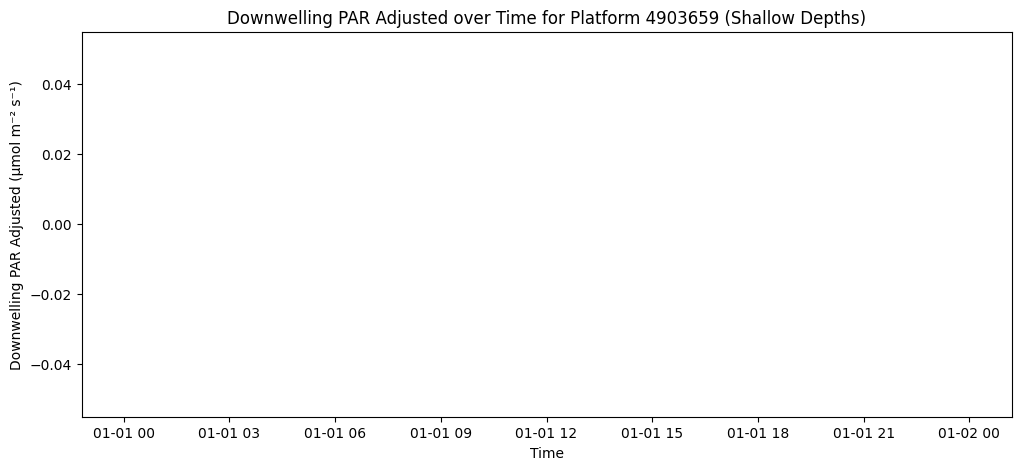

In [ ]:
# Extracting Platform number 4903659
df_float = df.filter(pl.col('PLATFORM_NUMBER') == 4903659)

#Assesing if it contais data at depth shallower than 1.3m

df_float_shallow = df_float.filter(pl.col('PRES_ADJUSTED') <= 130)

#Plotting downwelling_PAR_ADJUSTED

import matplotlib.pyplot as plt
df_float_shallow_pd = df_float_shallow.to_pandas()
df_float_shallow_pd["TIME"] = pd.to_datetime(df_float_shallow_pd["TIME"])
plt.figure(figsize=(12, 5))
plt.scatter(
        df_float_shallow_pd["TIME"],
        df_float_shallow_pd["DOWNWELLING_PAR_ADJUSTED"],
        s=10,
        alpha=0.6,
    )
plt.xlabel("Time")
plt.ylabel("Downwelling PAR Adjusted (µmol m⁻² s⁻¹)")
plt.title("Downwelling PAR Adjusted over Time for Platform 4903659 (Shallow Depths)")
plt.show()

In [ ]:
#plotting float